In [1]:
# import modules
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy.ma as ma
import numpy as np
import netCDF4 as nc4
import wx
import xarray as xr
%matplotlib inline

#pypago
import sys
sys.path.insert(0,"/home/albert/lib/python/pypago")
import os
import matplotlib
import pylab as plt
import numpy as np
from mpl_toolkits.basemap import Basemap


In [26]:
from mpl_toolkits.basemap import pyproj
ee = pyproj.Geod(ellps='GRS80') # ellipsoid used for distance calculation

def distance(lat1,lon1,lat2,lon2,geoid):
    az12,az21,dist = geoid.inv(lon1,lat1,lon2,lat2)
    return dist


In [2]:
gridname='/media/extra/DATA/NACHOS12.L75/NACHOS12.L75-I/NACHOS12.L75-MAA13_mesh_mask.nc'
dgrid=xr.open_dataset(gridname)


navlon=dgrid['nav_lon']
navlat=dgrid['nav_lat']


In [3]:
lon_ar7w_debut=np.array(-56).astype(np.float)
lon_ar7w_fin=np.array(-48).astype(np.float)

lat_ar7w_debut=np.array(53.5).astype(np.float)
lat_ar7w_fin=np.array(60.5).astype(np.float)



In [30]:
def loclatlon(navlon,navlat,lon,lat):
    ind_debut=np.where((navlon>lon-0.1)&(navlon<lon+0.1)&(navlat>lat-0.1)&(navlat<lat+0.1))
    dis=np.empty(len(ind_debut[0]))
    for ii in range(0,len(ind_debut[0])):
        dis[ii]=np.abs(distance(lat,lon,navlat[ind_debut[0][ii],ind_debut[1][ii]],navlon[ind_debut[0][ii],ind_debut[1][ii]],ee))
    ind=np.argmin(dis)
    i_debut=ind_debut[0][ind]
    j_debut=ind_debut[1][ind]
    
    return i_debut,j_debut
 

     

In [34]:
i_debut,j_debut=loclatlon(navlon,navlat,lon_ar7w_debut,lat_ar7w_debut)
i_fin,j_fin=loclatlon(navlon,navlat,lon_ar7w_fin,lat_ar7w_fin)

In [37]:
print i_debut,j_debut,i_fin,j_fin

1004 521 1134 631


In [71]:
def secfromdebuttofin(i_debut,j_debut,i_fin,j_fin):
    off=1
    fromi=np.atleast_1d(i_debut)+off
    fromj=np.atleast_1d(j_debut)+off
    toi=np.atleast_1d(i_fin)+off
    toj=np.atleast_1d(j_fin)+off

    veci=fromi
    vecj=fromj

    a=(toj-fromj)/((toi-fromi).astype(np.float))
    b=toj-toi*a

    while not((veci[-1]==toi) & (vecj[-1]==toj)):
        newi=veci[-1]+np.sign(toi-fromi)
        newj=vecj[-1]+np.sign(toj-fromj)
        y=a*newi+b
        x=(newj-b)/(a.astype(np.float))

        if ((np.abs(x-veci[-1]))>=(np.abs(y-vecj[-1]))):
            veci=np.append(veci,newi)
            vecj=np.append(vecj,vecj[-1])
        else:
            veci=np.append(veci,veci[-1])
            vecj=np.append(vecj,newj)

    veci=veci.astype(np.int)-off
    vecj=vecj.astype(np.int)-off

    dis=np.empty(len(veci))
    for ii in range(0,len(veci)):
        dis[ii]=np.abs(distance(navlat[veci[0],vecj[0]],navlon[veci[0],vecj[0]],navlat[veci[ii],vecj[ii]],navlon[veci[ii],vecj[ii]],ee))
    
    return veci,vecj,dis
            

In [72]:
veci,vecj,dis=secfromdebuttofin(i_debut,j_debut,i_fin,j_fin)

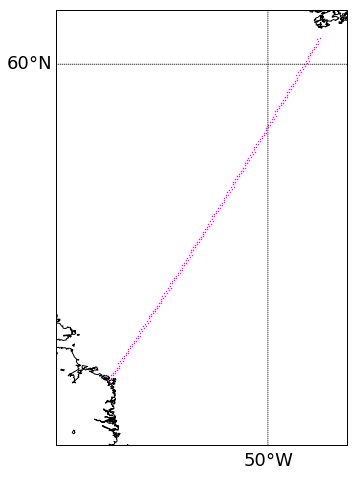

In [66]:
fig1 = plt.figure(figsize=(14, 8))  # (w,h)

my_map0 = Basemap(projection='merc', lat_0=55., lon_0=-50, 
resolution = 'i', 
llcrnrlon = -58, llcrnrlat = 52,
urcrnrlon = -47, urcrnrlat = 61, area_thresh = 10)

my_map0.drawcoastlines() 
my_map0.drawmapboundary()
my_map0.drawmeridians(np.arange(-120, 60, 10), labels=[1,0,0,1], size=18);
my_map0.drawparallels(np.arange(0, 80, 10), labels=[1,0,0,1], size=18);
for ii in range(0,len(veci)):
    my_map0.scatter(navlon[veci[ii],vecj[ii]].values, navlat[veci[ii],vecj[ii]].values, latlon=True, c='Magenta', linewidth='0', s=2)


In [ ]:
def extract_along_sec(var,veci,vecj):
    if np.ndim(var) == 4:
        [nt,nk,nj,ni]=var.shape
        var_sec=np.empty([nt,nk,len(veci)])
        for ii in range(0,len(veci)):
            var_sec[:,:,ii]=var[:,:,veci[ii],vecj[ii]]
    if np.ndim(var) == 3:
        [nt,nj,ni]=var.shape
        var_sec=np.empty([nt,len(veci)])
        for ii in range(0,len(veci)):
            var_sec[:,ii]=var[:,veci[ii],vecj[ii]]
    

In [88]:
wname='/media/extra/DATA/NACHOS12.L75/NACHOS12.L75-MAA13-S/NACHOS12.L75-MAA13_y2012m09d08.1d_gridW.nc'
dw=xr.open_dataset(wname)
w=dw['vovecrtz']
depthw=dw['depthw']

In [77]:
[nt,nk,nj,ni]=w.shape

In [78]:
var_sec=np.empty([nt,nk,len(veci)])

In [79]:
var_sec.shape

(1, 75, 241)

In [81]:
for ii in range(0,len(veci)):
    var_sec[:,:,ii]=w[:,:,veci[ii],vecj[ii]]

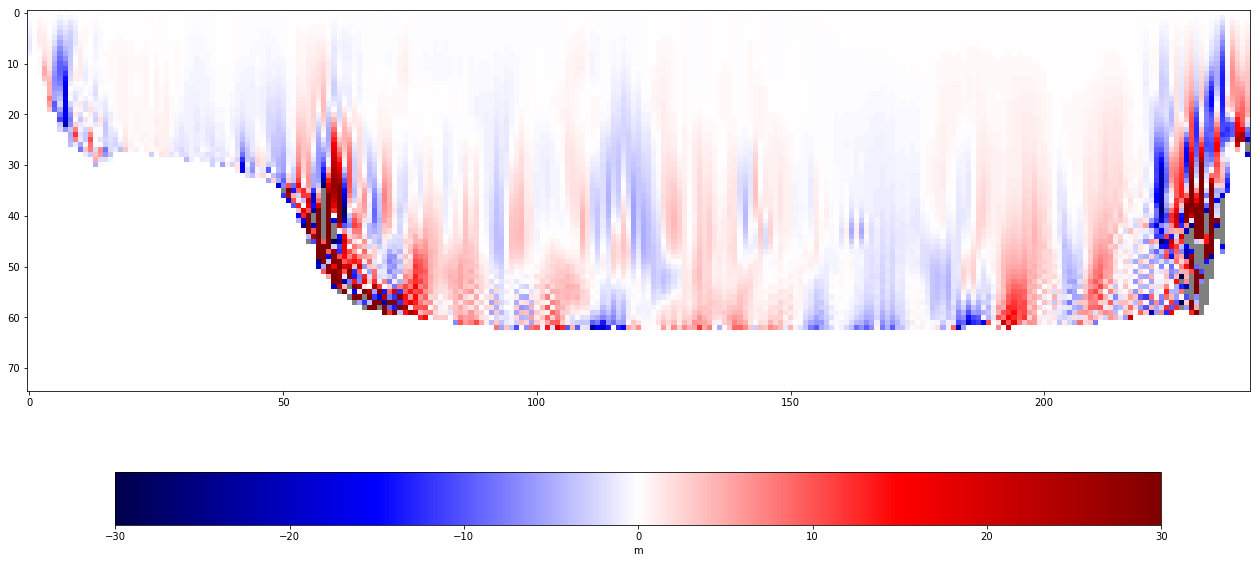

In [163]:
plt.figure(figsize=(25,10))
ax=plt.subplot()
cmap2 = plt.cm.seismic
pcolor=plt.imshow(86400*var_sec[0,:,:],interpolation='None',cmap=cmap2,vmin=-30,vmax=30)
cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75,label='m')


(65, 0)

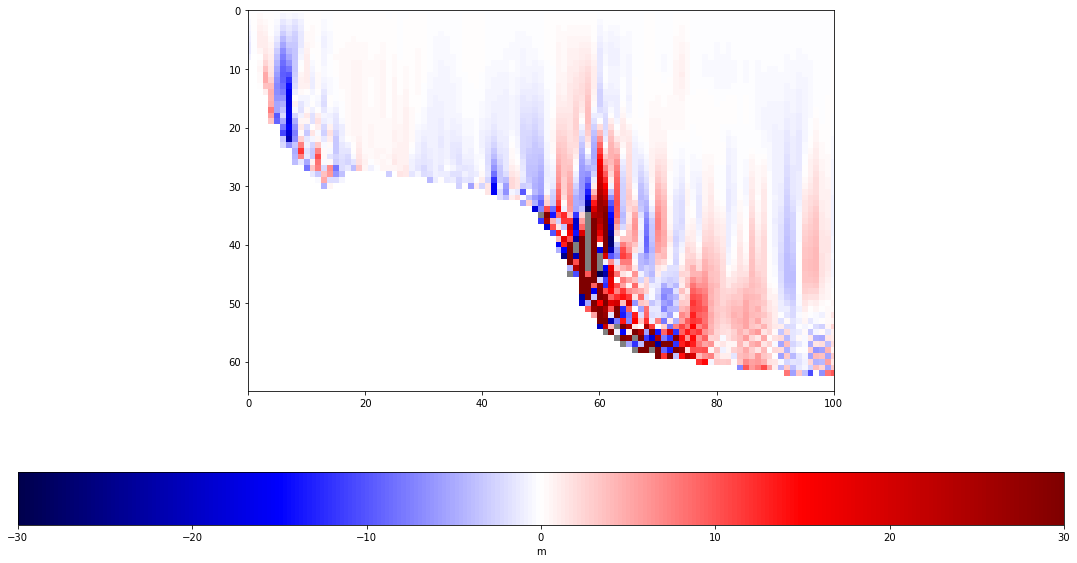

In [154]:
plt.figure(figsize=(25,10))
ax=plt.subplot()
cmap2 = plt.cm.seismic
pcolor=plt.imshow(86400*var_sec[0,:,:],interpolation='None',cmap=cmap2,vmin=-30,vmax=30)
plt.gca().invert_yaxis()
cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75,label='m')
ax.set_xlim(0,100)
ax.set_ylim(65,0)

(<xarray.DataArray 'depthw' ()>
 array(3995.354248046875, dtype=float32)
 Coordinates:
     depthw   float32 3995.35
 Attributes:
     long_name: Vertical W levels
     units: m
     axis: Z
     positive: down
     bounds: depthw_bounds, 0)

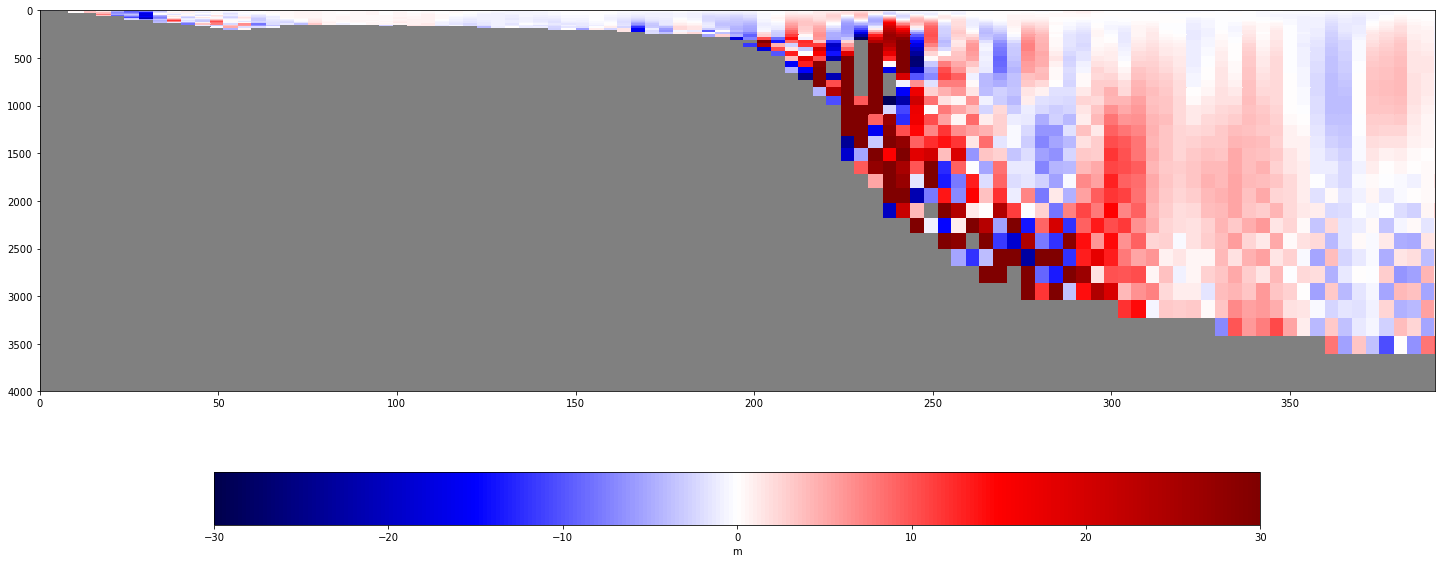

In [161]:
plt.figure(figsize=(25,10))
ax=plt.subplot()
cmap2 = plt.cm.seismic
pcolor=plt.pcolor(1e-3*dis,depthw,86400*var_sec[0,:,:],cmap=cmap2,vmin=-30,vmax=30)
plt.gca().invert_yaxis()
cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75,label='m')
ax.set_xlim(0,1e-3*dis[100])
ax.set_ylim(depthw[65],0)

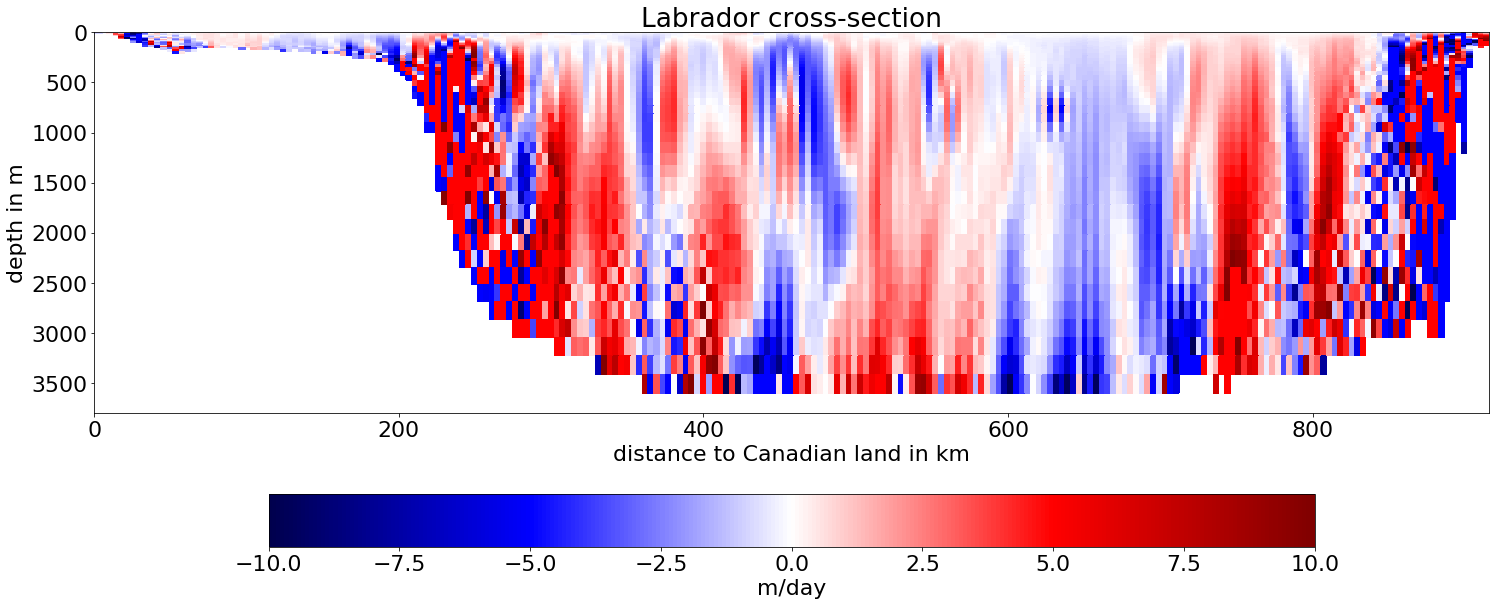

In [178]:
ma_var_sec = np.ma.array (var_sec, mask=np.isnan(var_sec))

matplotlib.rcParams.update({'font.size': 22})

plt.figure(figsize=(25,10))
ax=plt.subplot()
cmap2 = plt.cm.seismic
cmap2.set_under('b')
cmap2.set_over('r')
pcolor=plt.pcolor(1e-3*dis,depthw,86400*ma_var_sec[0,:,:],cmap=cmap2,vmin=-10,vmax=10)
plt.gca().invert_yaxis()
cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75,label='m/day')
ax.set_ylim(3800,0)
#ax.set_xlim(100,900)
plt.xlabel('distance to Canadian land in km')
plt.ylabel('depth in m')
plt.title('Labrador cross-section')